# **Style Transfer Algorithm**

In [1]:
import numpy as np
import scipy
import sklearn

## Dataset Loading

The datasets we used are as follow-


*   [Artist's Style](https://https://www.kaggle.com/datasets/ipythonx/van-gogh-paintings/)
*   [Content Image](https://www.kaggle.com/datasets/lprdosmil/unsplash-random-images-collection/)



In [ ]:
!pip install kaggle

In [3]:
kaggle_json_content = '{"username":"hkpandey","key":"32f0a1c6e7184ad7a6b91d1ff9858249"}'
with open('/content/kaggle.json', 'w') as kaggle_json:
    kaggle_json.write(kaggle_json_content)

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ipythonx/van-gogh-paintings/
!kaggle datasets download -d lprdosmil/unsplash-random-images-collection/

 96% 468M/485M [00:04<00:00, 79.0MB/s]
100% 485M/485M [00:04<00:00, 117MB/s] 
100% 26.8M/26.8M [00:00<00:00, 142MB/s] 
100% 26.8M/26.8M [00:00<00:00, 133MB/s]


In [6]:
custom_filepath = ['van-gogh-paintings','unsplash-random-images-collection']

In [7]:
import zipfile
import os

In [8]:
for path in custom_filepath:
  file_path = '/content/sample_data/'+path+'/'
  zip_name = path+'.zip'
  with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(file_path)
  os.remove(zip_name)

## Test-Train Split

### The input artist style dataset was partitioned into training and testing. Validation split was done later

In [9]:
import random
from sklearn.model_selection import train_test_split
from shutil import copyfile

Extracting the list of all the image files

In [60]:
def extracting(input_folder):
  image_files = []
  for f in os.listdir(input_folder):
    if f.endswith(('.jpg', '.png', '.jpeg')):
      image_files.append(f)

  return image_files

In [61]:
input_folder = "/content/sample_data/van-gogh-paintings/VincentVanGogh/Drawings/"

In [62]:
all_files = extracting(input_folder)

Splitting the list of all files in train and test

In [63]:
def split_dataset(all_files, output_folder, test_size, random_seed):
    # Splitted the dataset into training and testing sets
    train_files, test_files = train_test_split(all_files, test_size=test_size, random_state=random_seed)

    train_folder = os.path.join(output_folder, 'train/Vincent_van_Gogh')
    test_folder = os.path.join(output_folder, 'test/Vincent_van_Gogh')
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Copy training images to the train folder
    for file in train_files:
        src_path = os.path.join(input_folder, file)
        dest_path = os.path.join(train_folder, file)
        copyfile(src_path, dest_path)

    # Copy testing images to the test folder
    for file in test_files:
        src_path = os.path.join(input_folder, file)
        dest_path = os.path.join(test_folder, file)
        copyfile(src_path, dest_path)

In [64]:
output_folder = "/content/sample_data/"

In [65]:
split_dataset(all_files, output_folder,0.2,42)

## Loading the train and test data

In [13]:
images_dir1='/content/sample_data/train/'
test_images_dir1='/content/sample_data/test/'

In [14]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

Transformations for training and validation partition

In [66]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [67]:
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

A custom dataset class

In [68]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, split='train'):
        # Create an ImageFolder dataset using the specified directory and transformation
        self.data = ImageFolder(root=data_dir, transform=transform)
        self.classes = self.data.classes  # Extracted the classes from the ImageFolder dataset
        self.split = split
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

    def __len__(self):
        return len(self.data)

In [69]:
train_dataset = CustomDataset(data_dir=images_dir1, transform=train_transform, split='train')
valid_dataset = CustomDataset(data_dir=images_dir1, transform=valid_transform, split='valid')

In [70]:
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Transformations for Test Dataset

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
test_dataset = CustomDataset(data_dir=test_images_dir1, transform=test_transform, split='test')

In [ ]:
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Training the model on artist's style

We used the model VGG19 for our task

In [20]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [71]:
class CustomVGG19Regression(nn.Module):
    def __init__(self):
        super(CustomVGG19Regression, self).__init__()

        self.base_model = models.vgg19(pretrained=True)

        # Removed the layers present at the end
        self.features = self.base_model.features

        # Added custom layers
        self.regression_layers = nn.Sequential(
            nn.Flatten(),  # Flattened the output
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),  # Batch Normalization
            nn.ReLU(),  # ReLU Activation Function
            nn.Linear(512, 16),
            nn.BatchNorm1d(16),  # Batch Normalization
            nn.ReLU(),  # ReLU Activation Function
            nn.Linear(16, 1),  # Adjusting the output size based on the number of regression targets
            nn.Identity()
        )

    def forward(self, x):
        # Forward pass through the VGG19 feature extraction layers
        x = self.features(x)

        # Forward pass through the custom regression layers
        x = self.regression_layers(x)
        return x

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [73]:
# Assuming CustomVGG19Regression is the modified regression model
model_pytorch = CustomVGG19Regression()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
# Defining the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.0001)

In [25]:
# Defining the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [26]:
# Training loop
n_epoch = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pytorch.to(device)
criterion.to(device)

MSELoss()

In [77]:
for epoch in range(n_epoch):
    model_pytorch.train()
    running_loss = 0.0

    for inputs, _ in train_loader:  # Ignored the labels since we are doing regression
        inputs = inputs.to(device)

        # Set the parameter gradients to zero
        optimizer.zero_grad()

        # Forward pass
        outputs = model_pytorch(inputs)
        # Dummy target for validation
        labels = torch.zeros_like(outputs, requires_grad=False).to(device)

        # Computed the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation Phase
    model_pytorch.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, _ in valid_loader:
            inputs = inputs.to(device)

            # Forward pass
            outputs = model_pytorch(inputs)

            # Dummy target for validation
            labels = torch.zeros_like(outputs, requires_grad=False).to(device)

            # Compute the loss
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    # Updated the learning rate as per the feedback
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{n_epoch}, Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(valid_loader):.4f}')


KeyboardInterrupt: ignored

## Testing the trained model

In [75]:
model_pytorch.eval()
all_predictions = []
all_true_labels = []

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        # Forward pass
        outputs = model_pytorch(inputs)

        all_predictions.extend(outputs.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

Converted the list to a numpy array for uniformity

In [30]:
all_true_labels = np.array(all_true_labels)

Evaluated our regression predictions based on the following 4 errors:



* Mean Absolute Error(MAE)

In [ ]:
mae = mean_absolute_error(all_true_labels, all_predictions)
print(f'Mean Absolute Error: {mae:.4f}')

* Mean Squared Error(MSE)

In [ ]:
mse = mean_squared_error(all_true_labels, all_predictions)
print(f'Mean Squared Error: {mse:.4f}')

* Root Mean Sqaured Error(RMSE)

In [31]:
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.4f}')

* R2 Score

In [32]:
r2 = r2_score(all_true_labels, all_predictions)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.0239
Mean Absolute Error: 0.1365
R-squared: 0.0000
Root Mean Squared Error: 0.1547


## Saved the model

In [33]:
torch.save(model_pytorch.state_dict(), '/content/sample_data/custom_vgg19_model.pth')

## Style Transfer

Now we have model VGG19 trained on the artists dataset. We will use it's weights for style transfer

In [34]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torchvision import transforms, models

Creating a dict of random content images which we can retrieve randomly later

In [79]:
import os

In [83]:
def imList(base_path):
    i = 0
    image_files = {}
    for f in os.listdir(base_path):
        if f.endswith(('.jpg', '.png', '.jpeg')):
            # Get the full path of the file
            file_path = os.path.join(base_path, f)
            image_files[i] = file_path
            i += 1
    return image_files

In [85]:
base_image ='/content/sample_data/unsplash-random-images-collection/unsplash-images-collection/'

In [86]:
Images = imList(base_image)

Randomly selecting any one content image

In [94]:
i = np.random.randint(0, len(Images))

554

In [95]:
base_image_path = Images[i]

Creating a dict of style images which we can retrieve randomly later

In [101]:
style_path='/content/sample_data/train/Vincent_van_Gogh/'

In [102]:
S_Images = imList(base_image)

Randomly selecting any one style image

In [104]:
i = np.random.randint(0, len(S_Images))

In [105]:
style_image_path = S_Images[i]

Loading the trained VGG19

In [45]:
import torch
import torchvision.models as models

# Extracted the 'features' portion of VGG19
vgg = models.vgg19(pretrained=False).features  # pretrained = False because we will use our own weights

# Loaded our pre-trained weights
state_dict = torch.load('/content/sample_data/custom_vgg19_model.pth')

# Filtered out unnecessary keys
filtered_state_dict = {k: v for k, v in state_dict.items() if k in vgg.state_dict()}

# Loaded the filtered state dictionary
vgg.load_state_dict(filtered_state_dict, strict=False)  # Set strict to False to ignore missing keys

# Freezed all VGG parameters
for param in vgg.parameters():
    param.requires_grad_(False)


In [46]:
# Moved the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [47]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''

    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # Discarded the transparent, alpha channel (that's the :3) and added the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [48]:
# Helper function for de-normalizing an image # and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Loaded and pre-processed the style and content image

In [49]:
content = load_image(base_image_path).to(device)

In [ ]:
style = load_image(style_image_path, shape=content.shape[-2:]).to(device)

Displayed the content and style images

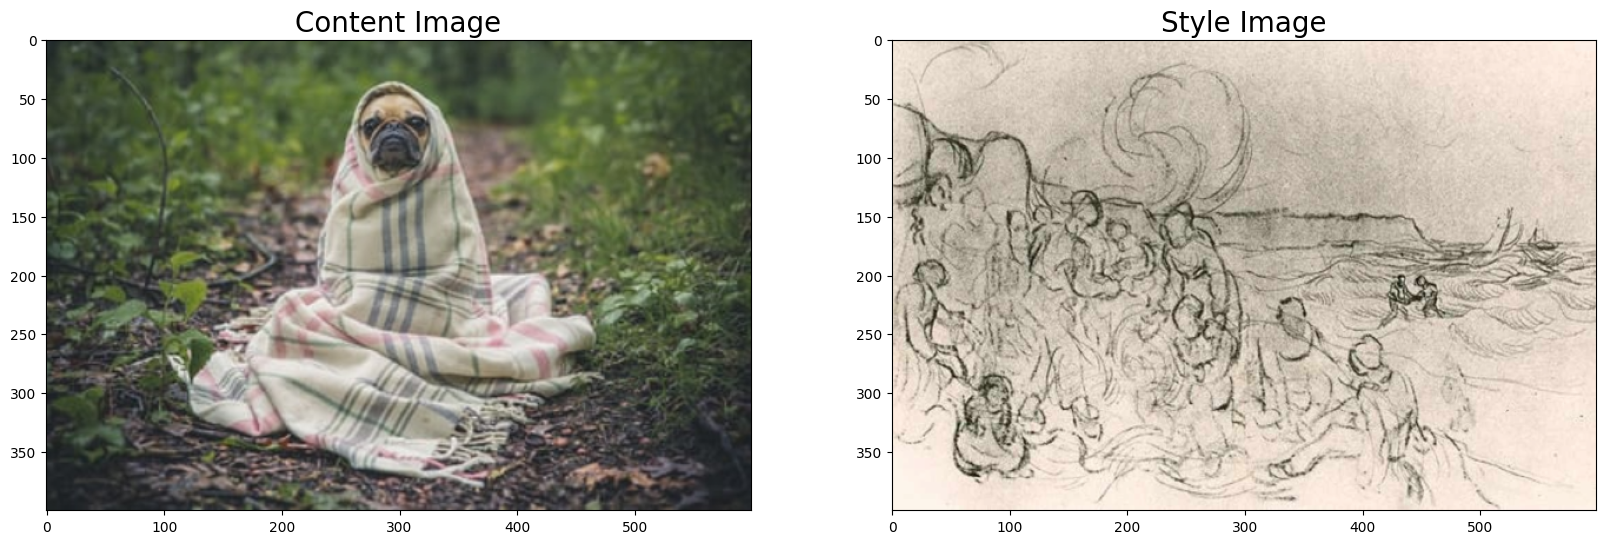

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize = 20)
plt.show()

In [106]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers.
    """

    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [107]:
def gram_matrix(tensor):
    """Calculated the Gram Matrix of the given tensor"""

    # get the shape of the tensor
    _, d, h, w = tensor.size()

    # Reshaping
    tensor = tensor.view(d, h * w)

    # calculated the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

In [52]:
# Got content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculated the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


Creating the target image

In [ ]:
target = content.clone().requires_grad_(True).to(device)

In [53]:
# weights for each style layer
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

## Content Loss and the Style Loss

In [54]:
# For displaying the target image, intermittently
show_every = 400

# Iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  #No. of iterations

for ii in range(1, steps+1):

    #Extracted features from target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # updated our target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

Displayed the result

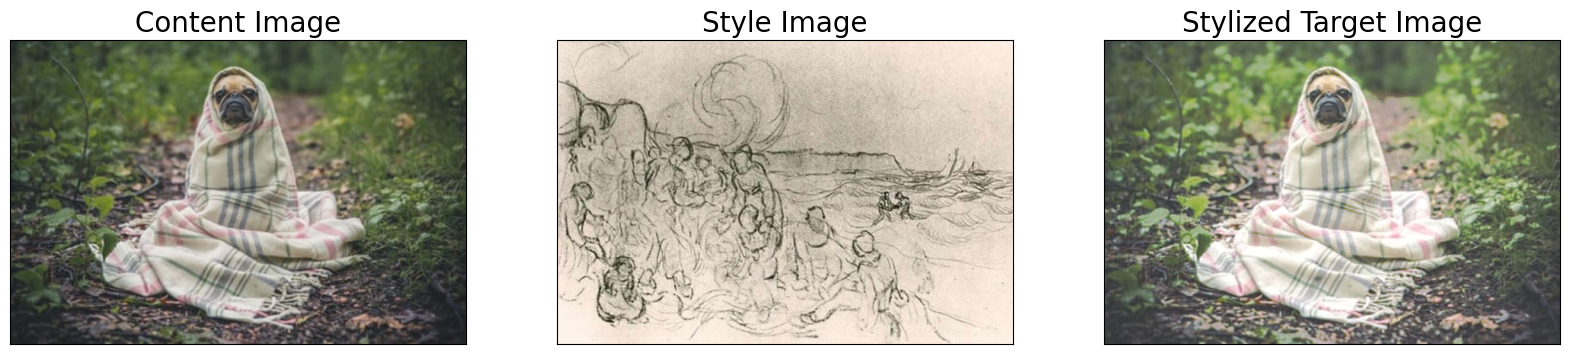

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=20)

ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize=20)

ax3.imshow(im_convert(target))
ax3.set_title("Stylized Target Image", fontsize=20)

# Hide axes ticks and grid
for ax in [ax1, ax2, ax3]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


### Save the stylized image

In [57]:
stylized_image = im_convert(target)
plt.imsave('/content/sample_data/stylized_image.png', stylized_image)

## SSIM value - Evaluation Metric

SSIM, or Structural Similarity Index, is a measure that tells us how similar two images are. It looks at things like brightness, contrast, and structure to figure out how much the images have in common visually.

The SSIM index gives us a number between -1 and 1:

*   If it's 1, the images are exactly the same
*   If it's 0, there's no similarity
*   If it's -1, the images are completely different

In [108]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [ ]:
def calculate_ssim(original, stylized):
    # Convert images to grayscale as SSIM is typically used for grayscale images
    original_gray = np.array(original.convert('L'))
    stylized_gray = np.array(stylized.convert('L'))

    # Ensure the images have the same shape
    min_shape = min(original_gray.shape, stylized_gray.shape)
    original_gray = original_gray[:min_shape[0], :min_shape[1]]
    stylized_gray = stylized_gray[:min_shape[0], :min_shape[1]]

    # Calculate SSIM
    ssim_value = ssim(original_gray, stylized_gray)

    return ssim_value

In [ ]:
def display_images(original, stylized, title1='Original', title2='Stylized'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original)
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(stylized)
    axes[1].set_title(title2)
    axes[1].axis('off')

    plt.show()

In [ ]:
# Assuming you have 'original_image.jpg' and 'stylized_image.jpg'
original_image_path = base_image_path
stylized_image_path = '/content/sample_data/stylized_image.png'

# Load images
original_image = Image.open(original_image_path)
stylized_image = Image.open(stylized_image_path)

# Display images
display_images(original_image, stylized_image)

# Calculate SSIM
ssim_value = calculate_ssim(original_image, stylized_image)
print(f'SSIM: {ssim_value}')